# Introduction to Monte Carlo Integration

Inspired from the following posts:

* http://nbviewer.jupyter.org/github/cs109/content/blob/master/labs/lab7/GibbsSampler.ipynb
* http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/
* https://en.wikipedia.org/wiki/Monte_Carlo_integration

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from numba import jit # Use it for speed

from scipy import stats

## What is Monte Carlo (MC) Integration?

Let us say that we want to approximate the area between the curve defined by $f(x) = x^2 + 3x + \ln{x}$ between $x\in (0,5]$ and the x-axis.

1.0 5.0
4.0 41.6094379124


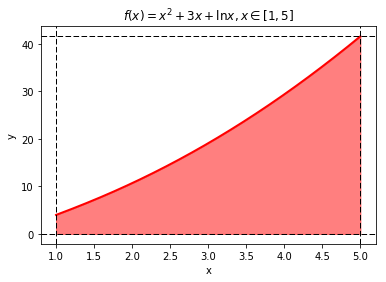

In [2]:
def f(x):
    return x**2 + 3*x + np.log(x)

step= 0.001
x = np.arange(1,5+step*0.1,step)
y = f(x)
print x.min(), x.max()
print y.min(), y.max()
plt.plot(x, y, lw=2., color="r")
plt.fill_between(x, 0, y, color="r", alpha=0.5)
plt.axhline(y=0, lw=1., color="k", linestyle="--")
plt.axhline(y=y.max(), lw=1., color="k", linestyle="--")
plt.axvline(x=x.min(), lw=1., color="k", linestyle="--")
plt.axvline(x=x.max(), lw=1., color="k", linestyle="--")
plt.xlabel("x")
plt.ylabel("y")
plt.title("$f(x) = x^2 + 3x + \ln{x}, x\in[1,5]$")

Concretely, we are interested in knowing the area of the red-shaded region in the above figure. Furthermore, I have also provided a rectangular bounding box for the range of values of $x$ and $y$. The true value of the area under the curve is $\sim{81.381}$ using its analytic integral formula (see http://www.wolframalpha.com/input/?i=integrate+x%5E2+%2B+3x+%2B+ln(x),+x+in+%5B1,5%5D).

The most accurate way to get the value of the area is to find the value of the definite integral $\int_{1}^{5} f(x) dx$. However, in many cases analytically finding this integral is very tough, especially if the function is not easily integrable. This is where numerical methods for approximating the integral come handy. Monte Carlo (MC) techniques are one of the most popular form of numerical solution used for definite integral calculation.

A basic intuition of the Monte Carlo Integration is as follows:
* Define the input domain $[a, b]$ of the integral $\int_{a}^{b} f(x) dx$.
* Uniformly, sample $N$ points from rectangular region between $[a, b)$ and $[\min(f(x)), \max(f(x)))$
* Find the proportion of points that lie in the region included in the area of $f(x)$, call it $p$
* Multiply the area of the rectangular region ($A$) by $p$ to get the area under the curve $A^*=p*A$
* As $N \to \infty$, the area of the shaded region $A^* \to \int_{a}^{b} f(x) dx$
* Usually, a much smaller value of $N$ will give approximate value within a reasonable error span.


Below, we will try to approximate the area of the curve using the MC integration method described above. We will use $N = 10^5$, and plot the points which fall in the region of the area in red and the other points in grey.

In [3]:
@jit
def get_MC_area(x, y, f, N=10**5, plot=False):
    x_rands = x.min() + np.random.rand(N) * (x.max() - x.min())
    y_rands = np.random.rand(N) * y.max()
    y_true = f(x_rands)
    integral_idx = (y_rands <= y_true)
    if plot:
        plt.plot(x_rands[integral_idx], y_rands[integral_idx],
                 alpha=0.3, color="r", linestyle='none',
                 marker='.', markersize=0.5)
        plt.plot(x_rands[~integral_idx], y_rands[~integral_idx],
                 alpha=0.3, color="0.5", linestyle='none',
                 marker='.', markersize=0.5)
        plt.axhline(y=0, lw=1., color="k", linestyle="--")
        plt.axhline(y=y.max(), lw=1., color="k", linestyle="--")
        plt.axvline(x=x.min(), lw=1., color="k", linestyle="--")
        plt.axvline(x=x.max(), lw=1., color="k", linestyle="--")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("$f(x) = x^2 + 3x + \ln{x}, x\in[1,5]; N=%s$" % N)
        print "Proportion points in space: %.3f" % (integral_idx).mean()
    area = (integral_idx).mean() * (
        (x_rands.max() - x_rands.min()) * (y_rands.max() - y_rands.min())
    )
    return area
    

/home/entity/anaconda2/lib/python2.7/site-packages/numba/dataflow.py:346: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)


Proportion points in space: 0.490

Area is: 81.533


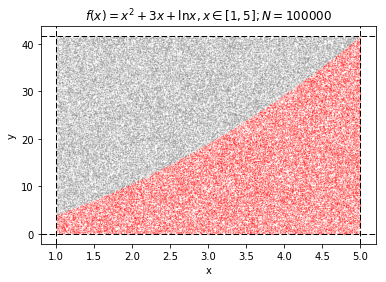

In [4]:
area = get_MC_area(x, y, f, N=10**5, plot=True)
print "Area is: %.3f" % area

As we can observe, the number of points which fall inside the region of interest, are proportional to the area of the region. The area however, marginally close to the true area of $81.38$. Let us also try with a higher value of $N=10^7$

Proportion points in space: 0.489

Area is: 81.398


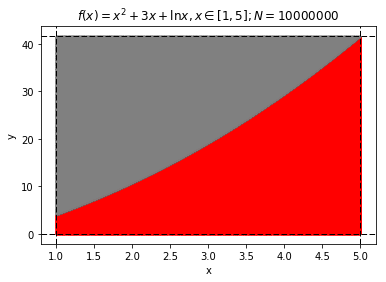

In [5]:
area = get_MC_area(x, y, f, N=10**7, plot=True)
print "Area is: %.3f" % area

The above figure, shows that for $N=10^7$, the region covered by the sampled points is almost as smooth as the shaded region. Furthermore, the area is closer to the true value of $81.38$.

Now, let us also analyze, how the value of the calculated area changes with the order of number of sampled points. 

In [6]:
for i in xrange(2,8):
    area = get_MC_area(x, y, f, N=10**i, plot=False)
    print i, area

2 88.0738917212
3 74.327056357
4 80.2320526499
5 81.0771326803
6 81.2459063119
7 81.4131110967


Clearly, as the number of points increase, the area becomres closer to the true value.

Let us further examine this change by starting with $10^3$ points and then going all the way till $10^6$ points. 

In [7]:
%%time
N_vals = 1000 + np.arange(1000)*1000
areas = np.zeros_like(N_vals, dtype="float")
for i, N in enumerate(N_vals):
    area = get_MC_area(x, y, f, N=N, plot=False)
    areas[i] = area

CPU times: user 36.4 s, sys: 3.63 s, total: 40 s
Wall time: 40 s


In [8]:
print "Mean area of last 100 points: %.3f" % np.mean(areas[-100:])
print "Areas of last 10 points: ", areas[-10:]

Mean area of last 100 points: 81.380
Areas of last 10 points:  [ 81.41165876  81.31764473  81.57499032  81.35316251  81.40445249
  81.41623796  81.46210595  81.4105668   81.4002441   81.34190896]


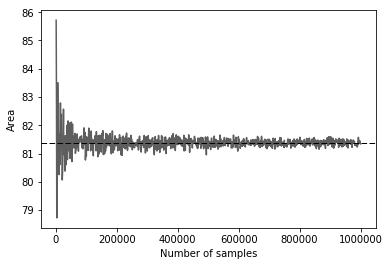

In [9]:
plt.plot(N_vals, areas, color="0.1", alpha=0.7)
plt.axhline(y=np.mean(areas[100:]), linestyle="--", lw=1., color="k")
plt.ylabel("Area")
plt.xlabel("Number of samples")
#plt.xscale("log")

As we can observe from the figure above, for lower number of sampled points, the estimates of MC integration are quite noisy. However, for larger number of points this value converges to the true estimates. 